In [264]:
import numpy as np
from scipy.stats import lognorm, uniform, norm
import matplotlib.pyplot as plt
import os
from fitting_models_rothenhoefer import value_efficient_coding_moment
import pickle as pkl

In [265]:
plt.rcParams.update(plt.rcParamsDefault)

In [266]:
# function that estimates not only slope but also intercept
def estimate_slope_fitwith_intercept(x, y, return_intercept=False):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x, y)
    if return_intercept:
        return model.coef_[0][0], model.intercept_[0]
    else:
        return model.coef_[0][0]


# fitting mse

In [267]:
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')

In [268]:
def fitting_line_lsq(params, debug=False):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[0]
    # others uses res.x
    R_t = params[2]
    # R_t = 150
    slope_scale_norm = params[1]
    slope_scale_unfm = params[1]

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # if any of alpha is larger than 1, return a large number
    if alpha_norm > 1 or alpha_unfm > 1:
        return 1e5

    # resonable range of R_t as bound
    if R_t < 100 or R_t > 200:
        return 1e5

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        # print(samples)
        norm_neg = ec_norm.neurons_[i][2500]
        norm_0 = ec_norm.neurons_[i][5000]
        norm_pos = ec_norm.neurons_[i][7500]

        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))


        unfm_neg = ec_unfm.neurons_[i][2500]
        unfm_0 = ec_unfm.neurons_[i][5000]
        unfm_pos = ec_unfm.neurons_[i][7500]

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    if np.any(np.array(norm_res)<0) or np.any(np.array(unfm_res)<0):
        # print(norm_res)
        return 1e5

    # upper bound
    if np.any(np.array(norm_res)>8) or np.any(np.array(unfm_res)>8):
        # print(norm_res)
        # print max(norm_res)
        return 1e5

    data_ = np.concatenate([norm_res, unfm_res]).reshape(-1,2)

    #get index that sorting data in ascending order
    sort_idx = np.argsort(data[:,0])
    #get index that sorting data_ in ascending order
    sort_idx_ = np.argsort(data_[:,0])

    # calculate mean squared error
    dist = np.mean((data_[sort_idx_] - data[sort_idx])**2)
    # dist = np.sum((np.sort(np.array(norm_res)) - np.sort(data[:,0]))**2) + np.sum((np.sort(np.array(unfm_res)) - np.sort(data[:,1]))**2)
    print('*'*20)
    print(params)
    # print(norm_res, data[:,0])
    print(dist)

    # get difference between data[:,0] and unfm_res, data[:,1] and norm_res
    # return sum of squared difference
    if debug:
        return dist, data_
    else:
        return dist

# set seed paramters that linspaced between 0 and 1, 0 and 10
params_0 = np.linspace(0.01,1,4)
params_1 = np.linspace(0.01,10,4)
params_2 = np.linspace(100,200,4)

# make paramters using meshgrid
param = np.array(np.meshgrid(params_0, params_1, params_2)).T.reshape(-1,3)
# param = np.array(np.meshgrid(params_0, params_1, params_2, params_3)).T.reshape(-1,4)
# param = np.array(np.meshgrid(params_0, params_1, params_2, params_3, params_4 )).T.reshape(-1,5)



In [269]:
# off warning
import warnings
warnings.filterwarnings('ignore')


# scipy.optimize.minimize to minimize fitting function
import pickle as pkl
os.makedirs('res_fit_to_empirical_rothenhoefer_MSE_sort_shared', exist_ok=True)


from scipy.optimize import minimize
# use param
# for but every 10th number in range of len(param)
now = True
if now:
    for i in range(len(param)):
        # do the followings only if there is no file that need to be saved
        if os.path.isfile('./res_fit_to_empirical_rothenhoefer_MSE_sort_shared/'+'fitting_'+str(i)+'.pkl'):
            continue

        # print param with its name in a line
        print('param_'+str(i)+':', param[i].tolist())

        # line that separates
        print('------------------------------------')
        try:
            res = minimize(fitting_line_lsq, param[i].tolist(), method='Powell', options={'disp': True})
        except:
            continue
        # res = minimize(fitting, [0.5,0.5,0.5,0.5], method='Nelder-Mead', options={'disp': True})

        # save res to res_fit_to_empirical_rothenhoefer using pickle
        with open('./res_fit_to_empirical_rothenhoefer_MSE_sort_shared/'+'fitting_'+str(i)+'.pkl', 'wb') as f:
            pkl.dump(res, f)



# after fitting, not arbitrary

## all at once

In [270]:
# load all files in res_fit_to_empirical_rothenhoefer
files = os.listdir('./res_fit_to_empirical_rothenhoefer_MSE_sort_shared')
files = [f for f in files if f.endswith('.pkl')]
files.sort()

# make empty list
res = []
# for every file in files|
for f in files:
    # open file using pickle
    with open('./res_fit_to_empirical_rothenhoefer_MSE_sort_shared/'+f, 'rb') as f:
        res.append(pkl.load(f))


# ...and sorting in ascending order of fun
res_sorted = sorted(res, key=lambda x: x.fun)


# find that has lowest fun
res = res[np.argmin([r.fun for r in res])]
# print res
print(res)


dist, data_= fitting_line_lsq(res.x, debug=True)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.465945518833158
       x: [ 7.783e-01  2.065e-01  1.000e+02]
     nit: 5
   direc: [[ 0.000e+00  0.000e+00  1.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-3.020e-05  2.506e-07 -0.000e+00]]
    nfev: 514
********************
[  0.77833732   0.20652938 100.        ]
1.465945518833158


In [271]:
# ec_norm and ec_unfm with the fitted parameters
params = res.x

N_neurons = 40
alpha_norm = params[0]
alpha_unfm =params[0]
# others uses res.x
slope_scale_norm = params[1]
slope_scale_unfm = params[1]
# R_t = 150
R_t = params[2]
spon_act = 5
samples = 10000

# cal slopes using spon_act

ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)




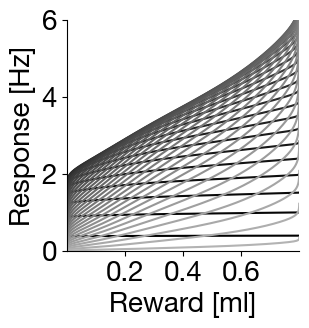

In [272]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


fig.set_figwidth(3)
fig.set_figheight(3)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
for i in range(ec_norm.N):
    plt.plot(ec_norm.x[:-2], ec_norm.neurons_[i][:-2], color=str(colors[i]))
    ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])
# set yticks that goes upto 6
ax.set_yticks([0,2,4,6])

plt.xlim([0, 0.8])
plt.ylim([0, 6])
plt.savefig('./figures_rothenhoefer/'+'neuron_norm_pop.png', bbox_inches="tight")
plt.show()



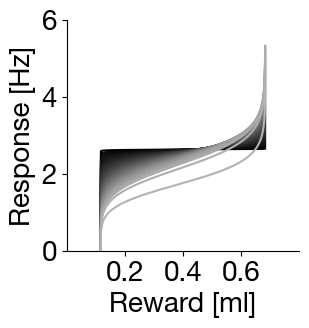

In [273]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


fig.set_figwidth(3)
fig.set_figheight(3)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
for i in range(ec_unfm.N):
    # plt.plot(ec_unfm.x[ec_unfm.p_prior!=0], ec_unfm.neurons_[i][ec_unfm.p_prior!=0], color=str(colors[i]))
    plt.plot(ec_unfm.x[1450:8532], ec_unfm.neurons_[i][1450:8532], color=str(colors[i]))
    ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])
ax.set_yticks([0,2,4,6])

plt.xlim([0, 0.8])
plt.ylim([0, 6])
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.pdf', bbox_inches="tight")
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.png', bbox_inches="tight")
plt.show()



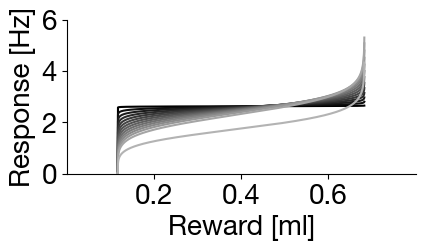

In [274]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.5)
fig.set_figheight(2)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        # plt.plot(ec_unfm.x[ec_unfm.p_prior!=0], ec_unfm.neurons_[i][ec_unfm.p_prior!=0], color=str(colors[i]))
        plt.plot(ec_unfm.x[1450:8532], ec_unfm.neurons_[i][1450:8532], color=str(colors[i]))
        ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])
ax.set_yticks([0,2,4,6])

plt.xlim([0, 0.8])
plt.ylim([0, 6])
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.pdf', bbox_inches="tight")
plt.show()



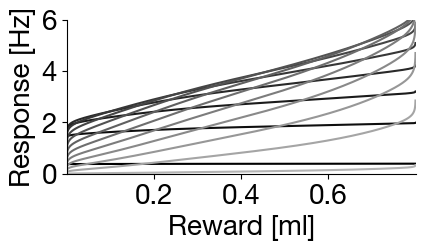

In [297]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.5)
fig.set_figheight(2)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_norm.x[:-2], ec_norm.neurons_[i][:-2], color=str(colors[i]))
        ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,2,4,6])

plt.xlim([0, 0.8])
plt.ylim([0, 6])
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.pdf', bbox_inches="tight")
plt.show()



# figure plans 1

figure that with the discrete overlay

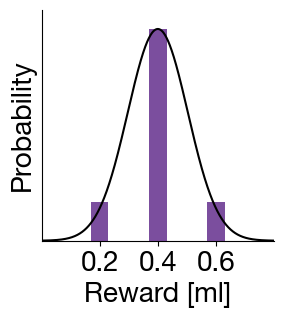

In [276]:
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

# set the maximum of ec_norm.p_prior as 11/15
ec_norm.p_prior = ec_norm.p_prior/np.max(ec_norm.p_prior)*11/15
# ec_norm.p_prior = ec_norm.p_prior/15*11

ax.plot(ec_norm.x, ec_norm.p_prior, color=[0,0,0])
# barplot of [0.2, 0.4, 0.6] and [2/15. 11/15, 2/15]
ax.bar([0.2, 0.4, 0.6], [2/15, 11/15, 2/15], width=0.06, color='#7b4e9e')

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Probability')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
ax.set_xticks([.2, .4, .6])
# ax.set_yticks([0,.2,.4,.6,.8])
ax.set_yticks([])
fig.set_figwidth(3)
fig.set_figheight(3)

# set size of figure


fig.savefig('./figures_rothenhoefer/'+'normal_distribution.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'normal_distribution.pdf', bbox_inches="tight")
# fig.savefig('./figures_rothenhoefer/'+'normal_distribution.png')
plt.show()


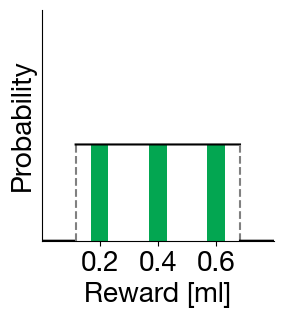

In [277]:
%matplotlib inline
ind_init, ind_term = np.where(ec_unfm.p_prior>0)[0][[0,-1]]
ind_term += 1
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

ec_unfm.p_prior = ec_unfm.p_prior/np.max(ec_unfm.p_prior)*5/15

ax.plot(ec_unfm.x[:ind_init], ec_unfm.p_prior[:ind_init], color=[0,0,0])
ax.plot([ec_unfm.x[ind_init],ec_unfm.x[ind_init]], [0, ec_unfm.p_prior[ind_init]], '--', color='0.5')
ax.plot(ec_unfm.x[ind_init:ind_term], ec_unfm.p_prior[ind_init:ind_term], color=[0,0,0])
ax.plot([ec_unfm.x[ind_term],ec_unfm.x[ind_term]], [0, ec_unfm.p_prior[ind_term-1]], '--', color='0.5')
ax.plot(ec_unfm.x[ind_term:], ec_unfm.p_prior[ind_term:], color=[0,0,0])

# ax.plot(ec_unfm.x, ec_unfm.p_prior, color=[0,0,0])



ax.bar([0.2, 0.4, 0.6], [5/15, 5/15, 5/15], width=0.06, color='#03a651')

ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Probability')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
ax.set_xticks([.2, .4, .6])
# ax.set_yticks([0,.2,.4,.6,.8])
ax.set_yticks([])
fig.set_figwidth(3)
fig.set_figheight(3)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'uniform_distribution.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'uniform_distribution.pdf', bbox_inches="tight")

In [278]:
# N_neurons = 40
# alpha = 0.5
# # others uses res.x
# R_t = 150
# slope_scale = 0.3
# spon_act = 3.92
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
#


norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

(10000,)


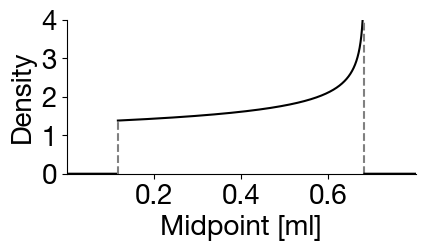

In [279]:
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

fig.set_figwidth(4.5)
fig.set_figheight(2)

midpoints = []
ymax = []
for i in range(ec_unfm.N):
    ymax.append(ec_unfm.neurons_[i][1499])

ax.set_xlabel('Midpoint [ml]')
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum()/ec_unfm._x_gap, color='k')

d_x = ec_unfm.d_x/ec_unfm.d_x.sum()/ec_unfm._x_gap
ax.plot(ec_unfm.x[:ind_init], d_x[:ind_init], color=[0,0,0])
ax.plot([ec_unfm.x[ind_init],ec_unfm.x[ind_init]], [0, d_x[ind_init]], '--', color='0.5')
ax.plot(ec_unfm.x[ind_init:ind_term], d_x[ind_init:ind_term], color=[0,0,0])
ax.plot([ec_unfm.x[ind_term],ec_unfm.x[ind_term]], [0, d_x[ind_term-1]], '--', color='0.5')
ax.plot(ec_unfm.x[ind_term:], d_x[ind_term:], color=[0,0,0])


ax.set_yticks(np.arange(0, 5,1))

plt.ylim([0, 4])
plt.xlim([0, 0.8])
print(ec_norm.d_x.shape)
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.pdf', bbox_inches="tight")
plt.show()


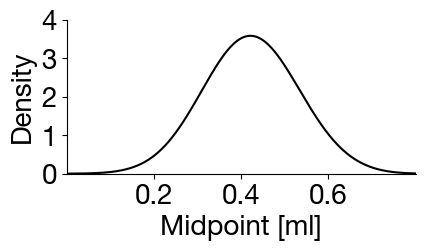

In [280]:
%matplotlib inline

plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.5)
fig.set_figheight(2)

midpoints=[]
ymax = []
for i in range(ec_norm.N):
    ymax.append(ec_norm.neurons_[i][1499])

    # check if every points in ec_norm.neurons_[i] is smaller than spon_act
    if not np.all(ec_norm.neurons_[i] < spon_act):
        # print(np.argmin(np.abs(ec_norm.neurons_[i] - spon_act)))
        # append midpoints that is ec_unfm.neurons_[i] is closest to spon_act
        midpoints.append(ec_norm.x[np.argmin(np.abs(ec_norm.neurons_[i] - spon_act))])
    else:
        # APPEND nothing to midpoints
        ''


ax.set_xlabel('Midpoint [ml]')
ax.set_ylabel('Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

# set clean y ticks
ax.set_yticks(np.arange(0, 5,1))

plt.ylim([0, 4])
plt.xlim([0, 0.8])


# normalize ec_norm.d_x so that area under curve is 1
ax.plot(ec_norm.x, ec_norm.d_x/ec_norm.d_x.sum()/ec_norm._x_gap, color='k')

fig.savefig('./figures_rothenhoefer/'+'normal_density.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'normal_density.pdf', bbox_inches="tight")
plt.show()

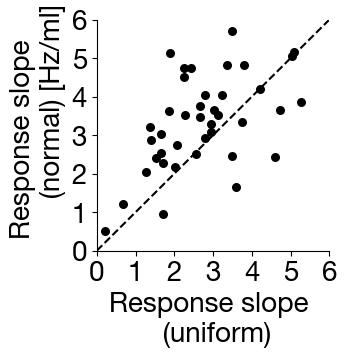

In [299]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1,1)
np.random.seed(15)

# scatter plot of scatter(unfm_res, norm_res) and scatter(data[0], data[1]) and overlay them semi transparent

#ax scatter of unfm_res and norm_res with label='ours'




# plot fitting line for scatter plot
# plt.plot(np.unique(unfm_res), np.poly1d(np.polyfit(unfm_res, norm_res, 1))(np.unique(unfm_res)))
ax.scatter(data[:,0], data[:,1], color='k',label='Measured data' ,s=30)
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0]))) but for data[:,0] and data[:,1]
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0])))

# ax.legend()

# ax.set_xlabel('Response slope (uniform)')
# ax.set_ylabel('Response slope (normal)')
ax.set_xlabel('Response slope \n (uniform)')
ax.set_ylabel('Response slope \n         (normal) [Hz/ml]')
# overlay y=x dashed line from 0 to 6
ax.plot([0,6], [0,6], 'k--')

ax.set_xlim([0, 6])
# set fig's ylim
ax.set_ylim([0, 6])

# set y ticks every 1
ax.set_xticks(np.arange(0, 7,1))
ax.set_yticks(np.arange(0, 7,1 ))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(3)
fig.set_figheight(3)


# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/'+'alpha_true_.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'alpha_true_.pdf', bbox_inches="tight")

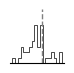

In [282]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
kws = dict(histtype= "stepfilled", linewidth = 0.5, edgecolor="k", alpha=1)
ax.hist(data[:,0]-data[:,1], bins=18, color= 'w', **kws)
# plot verical sloid line
ax.axvline(x=0, color=str(0.5), linestyle='--', linewidth=1)

ax.set_yticks([])
ax.set_xticks([])

ax.set_ylim([0, 10])

# set y ticks


fig.set_figwidth(0.7)
fig.set_figheight(0.7)
plt.show()
fig.savefig('./figures_rothenhoefer/'+'histo_ori.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'histo_ori.pdf', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [283]:
np.sum((np.array(data[:,0])-np.array(data[:,1]))<0)


31

In [284]:

# N_neurons = 40
# alpha = 0.7
# R_t = 150
# slope_scale = 0.3
# spon_act = 5
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

In [285]:
# wrapper_func_alpha_poisson but with one more argument that number of samples
def wrapper_func_alpha_poisson_samples(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = params[4]
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5
    samples = params[5]

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        # norm_neg -= spon_act
        # norm_0 -= spon_act
        # norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        # unfm_neg -= spon_act
        # unfm_0 -= spon_act
        # unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    return norm_res, unfm_res


In [286]:
# wrapper_func_alpha_poisson but with one more argument that number of samples
def wrapper_func_alpha(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = params[4]
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = ec_norm.neurons_[i][2500]
        norm_0 = ec_norm.neurons_[i][5000]
        norm_pos = ec_norm.neurons_[i][7500]

        # norm_neg -= spon_act
        # norm_0 -= spon_act
        # norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = ec_unfm.neurons_[i][2500]
        unfm_0 = ec_unfm.neurons_[i][5000]
        unfm_pos = ec_unfm.neurons_[i][7500]

        # unfm_neg -= spon_act
        # unfm_0 -= spon_act
        # unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    dist = np.sum((np.sort(np.array(norm_res)) - np.sort(data[:,0]))**2) + np.sum((np.sort(np.array(unfm_res)) - np.sort(data[:,1]))**2)

    print('dist:')
    print(dist)
    # sum of squared error
    dist = np.sum(dist**2)

    return norm_res, unfm_res


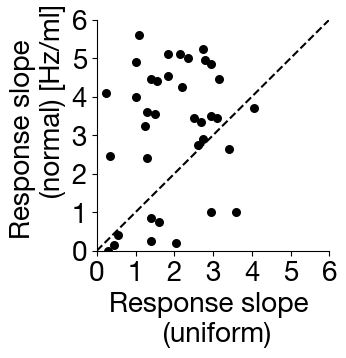

In [300]:
%matplotlib inline
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(1,1)
np.random.seed(0)

norm_res, unfm_res = wrapper_func_alpha_poisson_samples([alpha_norm, alpha_unfm, slope_scale_norm, slope_scale_unfm, R_t, 50])
# norm_res, unfm_res = wrapper_func_alpha([alpha_norm, alpha_unfm, slope_scale_norm, slope_scale_unfm, R_t])


#ax scatter of unfm_res and norm_res with label='ours'
# ax.scatter(data[:,0], data[:,1], color='r',label='Measured data' ,s=30)

ax.scatter(unfm_res, norm_res, color='k', label='Our model', s=30)
# ax.legend()

# ax.set_xlabel('Response slope (uniform)')
# ax.set_ylabel('Response slope (normal)')
ax.set_xlabel('Response slope \n (uniform)')
ax.set_ylabel('Response slope \n         (normal) [Hz/ml]')


ax.plot([0,6], [0,6], 'k--')

ax.set_xlim([0, 6])
# set fig's ylim
ax.set_ylim([0, 6])

# set y ticks every 1
ax.set_xticks(np.arange(0, 7,1))
ax.set_yticks(np.arange(0, 7,1 ))



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(3)
fig.set_figheight(3)

#legend but that is smaller
# ax.legend(fontsize=12)

# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/alpha_poisson_model.png', bbox_inches="tight")
# save in pdf
fig.savefig('./figures_rothenhoefer/alpha_poisson_model.pdf', bbox_inches="tight")


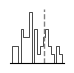

In [288]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
kws = dict(histtype= "stepfilled", linewidth = 0.5, edgecolor="k", alpha=1)
ax.hist(np.array(unfm_res)-np.array(norm_res), bins=18, color= 'w', **kws)
# plot verical sloid line
ax.axvline(x=0, color=str(0.5), linestyle='--', linewidth=1)


ax.set_yticks([])
ax.set_xticks([])
# set y ticks


fig.set_figwidth(.7)
fig.set_figheight(.7)
fig.savefig('./figures_rothenhoefer/'+'histo_our.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'histo_our.pdf', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [289]:
np.sum((np.array(unfm_res)-np.array(norm_res))<0)

29

# Figure

In [290]:
# load csv file that named 'data_dots.csv'
import pandas as pd
df = pd.read_csv('data_dots.csv')



In [291]:
# change data frame to numpy
green_line = df['Unnamed: 1'][1:4].to_numpy()
green_line = [float(datum) for datum in green_line]
green_dots = df['Unnamed: 5'][1:4].to_numpy()
green_dots = [float(datum) for datum in green_dots]
green_errs = df['Unnamed: 9'][1:7].to_numpy()
green_errs = [float(datum) for datum in green_errs]
green_errs = [green_errs[2*i]-green_errs[2*i+1] for i in range(3)]


purple_line = df['Unnamed: 3'][1:4].to_numpy()
purple_line = [float(datum) for datum in purple_line]
purple_dots = df['Unnamed: 7'][1:4].to_numpy()
purple_dots = [float(datum) for datum in purple_dots]
purple_errs = df['Unnamed: 11'][1:7].to_numpy()
purple_errs = [float(datum) for datum in purple_errs]
purple_errs = [purple_errs[2*i]-purple_errs[2*i+1] for i in range(3)]



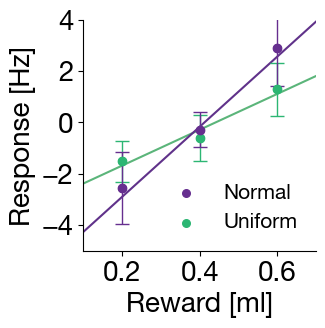

In [292]:
%matplotlib inline
ind = 25
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)


# estimate slope and intercept using estimate_slope_intercept function
slope1, intercept1 = estimate_slope_fitwith_intercept([0.2,0.4,0.6],green_line, return_intercept=True)
slope2, intercept2 = estimate_slope_fitwith_intercept([0.2,0.4,0.6],purple_line, return_intercept=True)

# plot lines
x = np.linspace(0,1,1000)
ax.plot(x, slope1*x+intercept1, color='#5BB57A')
ax.plot(x, slope2*x+intercept2, color='#60328A')



ax.scatter([0.2,0.4,0.6], purple_dots, color='#662f8f', label='Normal', s = 30)
ax.scatter([0.2,0.4,0.6], green_dots, color='#2cb673', label='Uniform',s = 30)

# plot error bar around green dots
ax.errorbar([0.2,0.4,0.6], green_dots, yerr=green_errs, fmt='o', color='#2cb673', capsize=5, elinewidth=1)
ax.errorbar([0.2,0.4,0.6], purple_dots, yerr=purple_errs, fmt='o', color='#662f8f', capsize=5, elinewidth=1)


ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')
ax.set_xticks([.2, .4, .6])
ax.set_yticks([-4,-2,0,2,4])

plt.xlim([0.1, 0.7])
plt.ylim([-5, 4])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(3)
fig.set_figheight(3)
#legend but without frame and tighter
ax.legend(frameon=False, loc='best', fontsize=15)


fig.savefig('./figures_rothenhoefer/'+'comparing.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'comparing.pdf', bbox_inches="tight")
plt.show()



In [293]:
# spontaneous activity is not

norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]
    norm_0 = ec_norm.neurons_[i][5000]
    norm_pos = ec_norm.neurons_[i][7500]
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]
    unfm_0 = ec_unfm.neurons_[i][5000]
    unfm_pos = ec_unfm.neurons_[i][7500]
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])


In [294]:
def estimate_slope_fitwith_intercept2(x, y, return_intercept=False):
    """
    Estimate slope and intercept of a line that passes through three points
    """
    x = np.array(x)
    y = np.array(y)
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    if return_intercept:
        return slope, intercept
    else:
        return slope

In [295]:
unfm_res[ind]

[2.020196722971618, 2.4976568416447043, 2.9777234057637236]

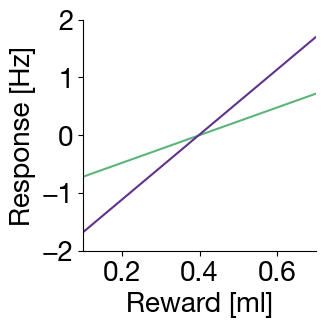

In [296]:
%matplotlib inline
ind = 25
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,1)

# return line that passes through three points of unfm_res[ind]
slope1, intercept1 = estimate_slope_fitwith_intercept([0.2,0.4,0.6],unfm_res[ind]-unfm_res[ind][1], return_intercept=True)
# return line that passes through three points of norm_res[ind]
slope2, intercept2 = estimate_slope_fitwith_intercept([0.2,0.4,0.6],norm_res[ind]-norm_res[ind][1], return_intercept=True)

# plot lines
x = np.linspace(-0.2,1,1000)
ax.plot(x, slope1*(x)+intercept1, color='#5BB57A')
ax.plot(x, slope2*(x)+intercept2, color='#60328A')
# # scatter plot of dots
# ax.scatter([0.2,0.4,0.6], unfm_res[ind]-unfm_res[ind][1], color='#5BB57A', label='Normal', s = 30)
# ax.scatter([0.2,0.4,0.6], norm_res[ind]-norm_res[ind][1], color='#60328A', label='Uniform',s = 30)


ax.set_xlabel('Reward [ml]')
ax.set_ylabel('Response [Hz]')
ax.set_xticks([.2, .4, .6])
# ax.set_yticks([-5,-4,-3,-2,-1,0,1,2,3,4])

plt.xlim([0.1, 0.7])
plt.ylim([-2, 2])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.set_figwidth(3)
fig.set_figheight(3)

#legend but that is smaller
# ax.legend(fontsize=12)
plt.show()

fig.savefig('./figures_rothenhoefer/'+'comparing_our.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'comparing_our.pdf', bbox_inches="tight")

